# Useful Resources

These are resources for imdb dataset:
- https://arxiv.org/pdf/1801.06146.pdf
- https://arxiv.org/pdf/1705.02364.pdf
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch
- https://www.kaggle.com/code/affand20/imdb-with-pytorch

# Prepare

In [ ]:
!pip install -q datasets
!pip install -q tqdm
!pip install -q seaborn
!pip install -q scikit-learn
!pip install -q pytorch_lightning
!pip install -q git+https://github.com/MagedSaeed/tkseem

  Preparing metadata (setup.py) ... done


In [ ]:
import re
import os
import random
import string
import shutil
from pathlib import Path

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

In [ ]:
seed = 42

In [ ]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and explore the dataset

In [ ]:
dataset = datasets.load_dataset("ag_news")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Converting to Pandas and droping duplicates

In [ ]:
train_dataset = dataset['train'].to_pandas()
train_dataset

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
train_dataset = train_dataset.drop_duplicates(subset=['text'],keep='first').copy()
train_dataset

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
test_dataset = dataset['test'].to_pandas()
test_dataset

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
test_dataset = test_dataset.drop_duplicates(subset=['text'],keep='first').copy()
test_dataset

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


Count positives and negatives

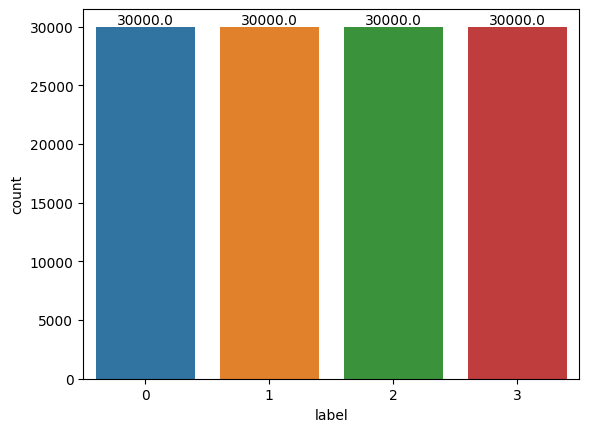

In [ ]:
# Create a count plot
ax = sns.countplot(data=train_dataset, x='label')
# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

trainset vocabulary and tokens count:


In [ ]:
vocabs_dict = {}
for document in train_dataset['text']:
  for word in document.split():
    vocabs_dict[word] = vocabs_dict.get(word,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('188,110', '4,541,694')

# Clean and Preprocess the dataset

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return text.translate(str.maketrans('', '', string.punctuation))

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    text = rm_link(text)
    text = rm_html(text)
    text = space_bt_punct(text)
    text = rm_punct2(text)
    text = rm_number(text)
    text = rm_whitespaces(text)
    text = rm_nonascii(text)
    text = rm_emoji(text)
    text = spell_correction(text)
    return text

In [ ]:
clean_pipeline('the hello world .')

'the hello world '

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)
    # return lemmas # let us say that we need the stop words :)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    tokens = rm_stopwords(tokens)
    tokens = lemmatize(tokens)
    return ' '.join(tokens)

def prepare(text):
  return preprocess_pipeline(clean_pipeline(text))

In [ ]:
# test the prepare method
prepare('the good, the bad, and the ugly!')

'good bad ugly'

In [ ]:
train_dataset['processed'] = list(train_dataset['text'].progress_apply(prepare))
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into Black Reuters Reu...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil Economy Cloud Stocks Outlook Reuters Reute...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports Main Southern Pipeline ...
4,"Oil prices soar to all-time record, posing new...",2,Oil price soar time record posing new menace U...
...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan Musharraf Says Won Quit Army Chief KA...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing top shelf deal Red Sox genera...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban going Dolphins yet The Miami Dolphins pu...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today NFL game PITTSBURGH NY GIANTS Time p Lin...


In [ ]:
test_dataset['processed'] = test_dataset['text'].progress_apply(prepare)
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed
0,Fears for T N pension after talks Unions repre...,2,Fears T N pension talk Unions representing wor...
1,The Race is On: Second Private Team Sets Launc...,3,The Race On Second Private Team Sets Launch Da...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant Study Peptides AP AP A c...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims Limit Farm Related Smog AP AP South...
...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around world Ukrainian presidential candidate ...
7596,Void is filled with Clement With the supply of...,1,Void filled Clement With supply attractive pit...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaf bitter Like Roger Clemens almost...
7598,5 of arthritis patients in Singapore take Bext...,2,arthritis patient Singapore take Bextra Celebr...


# create helper functions and set constants

In [ ]:
# Find out the max samples token
sorted_docs_by_length = sorted(tqdm(train_dataset['processed']),key=lambda document: len(document.split()),reverse=True)
len(sorted_docs_by_length[0].split()),\
len(sorted_docs_by_length[1].split()),\
len(sorted_docs_by_length[2].split()),\
len(sorted_docs_by_length[5].split()),\
len(sorted_docs_by_length[10].split()),\
len(sorted_docs_by_length[50].split()),\
len(sorted_docs_by_length[1000].split())

  0%|          | 0/120000 [00:00<?, ?it/s]

(132, 107, 107, 100, 98, 87, 54)

In [ ]:
# setting seq_len:
seq_len = 70

In [ ]:
def create_features_from_text_list(text_list,tokenizer):
  encoded = list()
  for doc in tqdm(text_list):
    encoded_doc = tokenizer.encode(doc)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
  return np.array(encoded)

In [ ]:
# define batch size
batch_size = 256

In [ ]:
def mask_vowels(text, mask=""):
    text_with_no_vowels = re.sub(
        r"[AEIOU]",
        mask,
        text,
        flags=re.IGNORECASE,
    )
    return text_with_no_vowels

# Build the BiGRU Model

In [ ]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        output_size=4,
        hidden_size=256,
        embedding_size=512,
        embedding_dropout=0.4,
        dropout=0.333,
        learning_rate=0.001,
        n_layers=4,
        bidirectional=True,
      ):
        super().__init__()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout

        self.train_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=output_size)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=output_size)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=output_size)

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)



    def forward(self, x):
        # outputs = x.long() # convert feature to long
        outputs = self.embedding(x)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        if not self.bidirectional:
          # pass forward to lstm
          outputs, _ =  self.lstm(outputs)
        else:
          lstm_outputs,_ = self.lstm(outputs)
          outputs = lstm_outputs[:, :, : self.hidden_size] + lstm_outputs[:, :, self.hidden_size :]
        # get last sequence output
        outputs = outputs[:, -1, :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        outputs = self(inputs)
        outputs = outputs.squeeze()
        return outputs

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        labels = labels.long()
        loss = F.cross_entropy(outputs, labels)
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        loss = F.cross_entropy(outputs, labels)
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        loss = F.cross_entropy(outputs, labels)
        test_accuracy = self.test_accuracy(outputs, labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [ ]:
def get_best_checkpoint(text_type,checkpoints_base_path="./TopciModeling"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [ ]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./TopciModeling/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=10,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Normal English

## Tokenize the dataset

In [ ]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
tokenizer.train(text='\n'.join(train_dataset['processed']))

Training WordTokenizer ...


In [ ]:
tokenizer.vocab_size

79037

In [ ]:
len([vocab for vocab,count in tokenizer.vocab.items() if count == 1 ])

27348

In [ ]:
tokenizer.vocab = dict({vocab:count for vocab,count in tokenizer.vocab.items() if count != 1})
tokenizer.vocab_size = len(tokenizer.vocab)
tokenizer.vocab_size

51689

In [ ]:
# test the tokenizer
tokenizer.tokenize('the hello world , fractionally')

['<UNK>', 'hello', 'world', '<UNK>', '<UNK>']

## tokenize and split

In [ ]:
encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed'],tokenizer=tokenizer)
trainy = train_dataset['label'].to_numpy()

encoded_testset = create_features_from_text_list(text_list=test_dataset['processed'],tokenizer=tokenizer)
testy = test_dataset['label'].to_numpy()

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
encoded_trainset, encoded_valset, trainy, valy = train_test_split(
  encoded_trainset,
  trainy,
  test_size=0.1,
  random_state=seed,
  stratify=trainy,
)
len(encoded_trainset),len(encoded_valset),len(trainy), len(valy)

(108000, 12000, 108000, 12000)

In [ ]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [ ]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [ ]:
model = LitBiLSTMModel(vocab_size=tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(51689, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='all-characters',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.3871991634368896     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 26.5 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 1.0 K 
---------------------------------------------------------
32.8 M    Trainable params
0         Non-trainable params
32.8 M    Total params
131.095   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters',),
    vocab_size=tokenizer.vocab_size,
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(51689, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer.test(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9169737100601196     │
│         test_loss         │     0.279387503862381     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9169737100601196, 'test_loss': 0.279387503862381}]

# Consonants only

In [ ]:
train_dataset['processed_only_consonants'] = train_dataset['processed'].progress_apply(mask_vowels)
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into Black Reuters Reu...,Wll St Brs Clw Bck nt Blck Rtrs Rtrs Shrt sllr...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...,Crlyl Lks Twrd Cmmrcl rspc Rtrs Rtrs Prvt nvst...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil Economy Cloud Stocks Outlook Reuters Reute...,l cnmy Cld Stcks tlk Rtrs Rtrs Srng crd prc pl...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports Main Southern Pipeline ...,rq Hlts l xprts Mn Sthrn Ppln Rtrs Rtrs thrts ...
4,"Oil prices soar to all-time record, posing new...",2,Oil price soar time record posing new menace U...,l prc sr tm rcrd psng nw mnc S cnmy FP FP Trwy...
...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan Musharraf Says Won Quit Army Chief KA...,Pkstn Mshrrf Sys Wn Qt rmy Chf KRCH Rtrs Pkstn...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing top shelf deal Red Sox genera...,Rntr sgnng tp shlf dl Rd Sx gnrl mngr Th pstn ...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban going Dolphins yet The Miami Dolphins pu...,Sbn gng Dlphns yt Th Mm Dlphns pt crtshp LS cc...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today NFL game PITTSBURGH NY GIANTS Time p Lin...,Tdy NFL gm PTTSBRGH NY GNTS Tm p Ln Stlrs Rcrd...


In [ ]:
train_dataset['processed_only_consonants'][0],train_dataset['processed'][0]

('Wll St Brs Clw Bck nt Blck Rtrs Rtrs Shrt sllr Wll Strt dwndlng bnd ltr cync sng grn',
 'Wall St Bears Claw Back Into Black Reuters Reuters Short seller Wall Street dwindling band ultra cynic seeing green')

In [ ]:
test_dataset['processed_only_consonants'] = test_dataset['processed'].progress_apply(mask_vowels)
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants
0,Fears for T N pension after talks Unions repre...,2,Fears T N pension talk Unions representing wor...,Frs T N pnsn tlk nns rprsntng wrkr Trnr Nwll s...
1,The Race is On: Second Private Team Sets Launc...,3,The Race On Second Private Team Sets Launch Da...,Th Rc n Scnd Prvt Tm Sts Lnch Dt Hmn Spcflght ...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant Study Peptides AP AP A c...,Ky Cmpny Wns Grnt Stdy Pptds P P cmpny fndd c...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...,Prdctn nt Hlps Frcst Wldfrs P P t brly dwn Mk ...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims Limit Farm Related Smog AP AP South...,Clf ms Lmt Frm Rltd Smg P P Sthrn Clfrn smg fg...
...,...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around world Ukrainian presidential candidate ...,rnd wrld krnn prsdntl cnddt Vktr Yshchnk psnd ...
7596,Void is filled with Clement With the supply of...,1,Void filled Clement With supply attractive pit...,Vd flld Clmnt Wth spply ttrctv ptchng ptn dwnd...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaf bitter Like Roger Clemens almost...,Mrtnz lf bttr Lk Rgr Clmns lmst xctly ght yr r...
7598,5 of arthritis patients in Singapore take Bext...,2,arthritis patient Singapore take Bextra Celebr...,rthrts ptnt Sngpr tk Bxtr Clbrx lt b gt lt b g...


In [ ]:
test_dataset['processed_only_consonants'][0],test_dataset['processed'][0]

('Frs T N pnsn tlk nns rprsntng wrkr Trnr Nwll sy dsppntd tlk strckn prnt frm Fdrl Mgl',
 'Fears T N pension talk Unions representing worker Turner Newall say disappointed talk stricken parent firm Federal Mogul')

In [ ]:
consonants_trainy = train_dataset['label'].to_numpy()

In [ ]:
consonants_testy = test_dataset['label'].to_numpy()

## create the tokenizer

In [ ]:
consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
consonants_tokenizer.train(text='\n'.join(train_dataset['processed_only_consonants']))

Training WordTokenizer ...


In [ ]:
consonants_tokenizer.vocab_size

54596

In [ ]:
len([vocab for vocab,count in consonants_tokenizer.vocab.items() if count == 1 ])

17283

In [ ]:
consonants_tokenizer.vocab = dict({vocab:count for vocab,count in consonants_tokenizer.vocab.items() if count != 1})
consonants_tokenizer.vocab_size = len(consonants_tokenizer.vocab)
consonants_tokenizer.vocab_size

37313

In [ ]:
# test the tokenizer
consonants_tokenizer.tokenize('th hll wrld , frctnlly')

['th', 'hll', 'wrld', '<UNK>', '<UNK>']

## tokenize and split

In [ ]:
consonants_encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed_only_consonants'],tokenizer=consonants_tokenizer)
consonants_encoded_testset = create_features_from_text_list(text_list=test_dataset['processed_only_consonants'],tokenizer=consonants_tokenizer)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
consonants_encoded_trainset, consonants_encoded_valset, consonants_trainy, consonants_valy = train_test_split(
  consonants_encoded_trainset,
  consonants_trainy,
  test_size=0.1,
  random_state=seed,
  stratify=consonants_trainy,
)
len(consonants_encoded_trainset),len(consonants_encoded_valset),len(consonants_trainy), len(consonants_valy)

(108000, 12000, 108000, 12000)

In [ ]:
# create tensor datasets
consonants_trainset = TensorDataset(torch.from_numpy(consonants_encoded_trainset), torch.from_numpy(consonants_trainy))
consonants_validset = TensorDataset(torch.from_numpy(consonants_encoded_valset), torch.from_numpy(consonants_valy))
consonants_testset = TensorDataset(torch.from_numpy(consonants_encoded_testset), torch.from_numpy(consonants_testy))

In [ ]:
# create dataloaders
consonants_trainloader = DataLoader(consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
consonants_valloader = DataLoader(consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
consonants_testloader = DataLoader(consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [ ]:
model = LitBiLSTMModel(vocab_size=consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(37313, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=consonants_trainloader,
    val_dataloader=consonants_valloader,
    text_type='consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     1.388010859489441     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 19.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 1.0 K 
---------------------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.652   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='consonants',),
    vocab_size=consonants_tokenizer.vocab_size,
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(37313, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer.test(model,consonants_testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.918026328086853     │
│         test_loss         │     0.265936940908432     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.918026328086853, 'test_loss': 0.265936940908432}]

# Masked Consonants

In [ ]:
train_dataset['processed_masked_consonants'] = list(train_dataset['processed'].progress_apply(lambda item: mask_vowels(item,mask="a")))
train_dataset

  0%|          | 0/120000 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants,processed_masked_consonants
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Wall St Bears Claw Back Into Black Reuters Reu...,Wll St Brs Clw Bck nt Blck Rtrs Rtrs Shrt sllr...,Wall St Baars Claw Back anta Black Raatars Raa...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Carlyle Looks Toward Commercial Aerospace Reut...,Crlyl Lks Twrd Cmmrcl rspc Rtrs Rtrs Prvt nvst...,Carlyla Laaks Taward Cammarcaal aaraspaca Raat...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Oil Economy Cloud Stocks Outlook Reuters Reute...,l cnmy Cld Stcks tlk Rtrs Rtrs Srng crd prc pl...,aal acanamy Claad Stacks aatlaak Raatars Raata...
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Iraq Halts Oil Exports Main Southern Pipeline ...,rq Hlts l xprts Mn Sthrn Ppln Rtrs Rtrs thrts ...,araq Halts aal axparts Maan Saatharn Papalana ...
4,"Oil prices soar to all-time record, posing new...",2,Oil price soar time record posing new menace U...,l prc sr tm rcrd psng nw mnc S cnmy FP FP Trwy...,aal praca saar tama racard pasang naw manaca a...
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,Pakistan Musharraf Says Won Quit Army Chief KA...,Pkstn Mshrrf Sys Wn Qt rmy Chf KRCH Rtrs Pkstn...,Pakastan Masharraf Says Wan Qaat army Chaaf Ka...
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Renteria signing top shelf deal Red Sox genera...,Rntr sgnng tp shlf dl Rd Sx gnrl mngr Th pstn ...,Rantaraa sagnang tap shalf daal Rad Sax ganara...
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Saban going Dolphins yet The Miami Dolphins pu...,Sbn gng Dlphns yt Th Mm Dlphns pt crtshp LS cc...,Saban gaang Dalphans yat Tha Maama Dalphans pa...
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Today NFL game PITTSBURGH NY GIANTS Time p Lin...,Tdy NFL gm PTTSBRGH NY GNTS Tm p Ln Stlrs Rcrd...,Taday NFL gama PaTTSBaRGH NY GaaNTS Tama p Lan...


In [ ]:
train_dataset['processed_masked_consonants'][0],train_dataset['processed'][0]

('Wall St Baars Claw Back anta Black Raatars Raatars Shart sallar Wall Straat dwandlang band altra cynac saaang graan',
 'Wall St Bears Claw Back Into Black Reuters Reuters Short seller Wall Street dwindling band ultra cynic seeing green')

In [ ]:
test_dataset['processed_masked_consonants'] = test_dataset['processed'].progress_apply(lambda item: mask_vowels(item,mask="a"))
test_dataset

  0%|          | 0/7600 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants,processed_masked_consonants
0,Fears for T N pension after talks Unions repre...,2,Fears T N pension talk Unions representing wor...,Frs T N pnsn tlk nns rprsntng wrkr Trnr Nwll s...,Faars T N pansaan talk anaans raprasantang war...
1,The Race is On: Second Private Team Sets Launc...,3,The Race On Second Private Team Sets Launch Da...,Th Rc n Scnd Prvt Tm Sts Lnch Dt Hmn Spcflght ...,Tha Raca an Sacand Pravata Taam Sats Laanch Da...
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Ky Company Wins Grant Study Peptides AP AP A c...,Ky Cmpny Wns Grnt Stdy Pptds P P cmpny fndd c...,Ky Campany Wans Grant Stady Paptadas aP aP a c...
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Prediction Unit Helps Forecast Wildfires AP AP...,Prdctn nt Hlps Frcst Wldfrs P P t brly dwn Mk ...,Pradactaan anat Halps Faracast Waldfaras aP aP...
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Calif Aims Limit Farm Related Smog AP AP South...,Clf ms Lmt Frm Rltd Smg P P Sthrn Clfrn smg fg...,Calaf aams Lamat Farm Ralatad Smag aP aP Saath...
...,...,...,...,...,...
7595,Around the world Ukrainian presidential candid...,0,Around world Ukrainian presidential candidate ...,rnd wrld krnn prsdntl cnddt Vktr Yshchnk psnd ...,araand warld akraanaan prasadantaal candadata ...
7596,Void is filled with Clement With the supply of...,1,Void filled Clement With supply attractive pit...,Vd flld Clmnt Wth spply ttrctv ptchng ptn dwnd...,Vaad fallad Clamant Wath sapply attractava pat...
7597,Martinez leaves bitter Like Roger Clemens did ...,1,Martinez leaf bitter Like Roger Clemens almost...,Mrtnz lf bttr Lk Rgr Clmns lmst xctly ght yr r...,Martanaz laaf battar Laka Ragar Clamans almast...
7598,5 of arthritis patients in Singapore take Bext...,2,arthritis patient Singapore take Bextra Celebr...,rthrts ptnt Sngpr tk Bxtr Clbrx lt b gt lt b g...,arthratas pataant Sangapara taka Baxtra Calabr...


In [ ]:
test_dataset['processed_masked_consonants'][0],test_dataset['processed'][0]

('Faars T N pansaan talk anaans raprasantang warkar Tarnar Nawall say dasappaantad talk strackan parant farm Fadaral Magal',
 'Fears T N pension talk Unions representing worker Turner Newall say disappointed talk stricken parent firm Federal Mogul')

In [ ]:
masked_consonants_trainy = train_dataset['label'].to_numpy()

In [ ]:
masked_consonants_testy = test_dataset['label'].to_numpy()

## create the tokenizer

In [ ]:
masked_consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
masked_consonants_tokenizer.train(text='\n'.join(train_dataset['processed_masked_consonants']))

Training WordTokenizer ...


In [ ]:
masked_consonants_tokenizer.vocab_size

67982

In [ ]:
len([vocab for vocab,count in masked_consonants_tokenizer.vocab.items() if count == 1 ])

22660

In [ ]:
masked_consonants_tokenizer.vocab = dict({vocab:count for vocab,count in masked_consonants_tokenizer.vocab.items() if count != 1})
masked_consonants_tokenizer.vocab_size = len(masked_consonants_tokenizer.vocab)
masked_consonants_tokenizer.vocab_size

45322

In [ ]:
# test the tokenizer
masked_consonants_tokenizer.tokenize('tha halla warld , fractaanally')

['<UNK>', 'halla', 'warld', '<UNK>', '<UNK>']

## tokenize and split

In [ ]:
masked_consonants_encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed_masked_consonants'],tokenizer=masked_consonants_tokenizer)
masked_consonants_encoded_testset = create_features_from_text_list(text_list=test_dataset['processed_masked_consonants'],tokenizer=masked_consonants_tokenizer)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
masked_consonants_encoded_trainset, masked_consonants_encoded_valset, masked_consonants_trainy, masked_consonants_valy = train_test_split(
  masked_consonants_encoded_trainset,
  masked_consonants_trainy,
  test_size=0.1,
  random_state=seed,
  stratify=masked_consonants_trainy,
)
len(masked_consonants_encoded_trainset),len(masked_consonants_encoded_valset),len(masked_consonants_trainy), len(masked_consonants_valy)

(108000, 12000, 108000, 12000)

In [ ]:
# create tensor datasets
masked_consonants_trainset = TensorDataset(torch.from_numpy(masked_consonants_encoded_trainset), torch.from_numpy(masked_consonants_trainy))
masked_consonants_validset = TensorDataset(torch.from_numpy(masked_consonants_encoded_valset), torch.from_numpy(masked_consonants_valy))
masked_consonants_testset = TensorDataset(torch.from_numpy(masked_consonants_encoded_testset), torch.from_numpy(masked_consonants_testy))

In [ ]:
# create dataloaders
masked_consonants_trainloader = DataLoader(masked_consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
masked_consonants_valloader = DataLoader(masked_consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
masked_consonants_testloader = DataLoader(masked_consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [ ]:
model = LitBiLSTMModel(vocab_size=masked_consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(45322, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=masked_consonants_trainloader,
    val_dataloader=masked_consonants_valloader,
    text_type='masked-consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.3874702453613281     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 23.2 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 1.0 K 
---------------------------------------------------------
29.5 M    Trainable params
0         Non-trainable params
29.5 M    Total params
118.055   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants',),
    vocab_size=masked_consonants_tokenizer.vocab_size,
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(45322, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
trainer.test(model,masked_consonants_testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9167105555534363     │
│         test_loss         │    0.2698819041252136     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9167105555534363, 'test_loss': 0.2698819041252136}]